In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from encoder.digit_encoder import small_int_vector_asimage
from sparse_causal_model_learner_rl.trainable.combined import FCCombinedModel
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
from sparse_causal_model_learner_rl.loss.losses import manual_switch_gradient
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, LearnableSwitchSimple
import seaborn as sns
from functools import partial
from tqdm.auto import tqdm
import pandas as pd
from causal_util.helpers import lstdct2dctlst
from math import ceil
import gin
from causal_util import load_env
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
load_config_files(['../sparse_causal_model_learner_rl/configs/rl_const_sparsity_obs_space.gin',
                   '../sparse_causal_model_learner_rl/configs/env_ve2.gin'])
gin.enter_interactive_mode()
import ray

In [3]:
device = torch.device('cuda')
# device = torch.device('cpu')

In [4]:
ray.init(ignore_reinit_error=True)
learner = CausalModelLearnerRL(Config(disable_cuda=True, minibatch_size=1000, context_transforms=[]))

2021-02-24 18:27:12,054	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8266
2021-02-24 18:27:14,931	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 895333a8-76c5-11eb-8443-c91591eaaf9b
Make environment VectorIncrement-v0 None {}
(pid=27742) Make environment VectorIncrement-v0 None {}
(pid=27737) Make environment VectorIncrement-v0 None {}
(pid=27739) Make environment VectorIncrement-v0 None {}


In [5]:
def fill_data():
    global ctx, obs, obs_next, actions
    ctx = learner.collect_and_get_context()
    obs_next = ctx['obs_y'].to(device)
    obs = ctx['obs_x'].to(device)
    actions = ctx['action_x'].to(device)
fill_data()

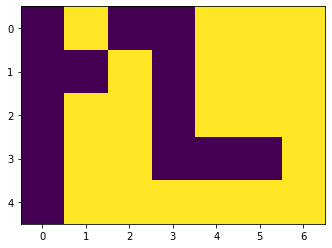

In [6]:
plt.imshow(obs[0].detach().cpu().numpy())

In [7]:
obs_std = obs.std(0, keepdim=True)
obs_std = torch.where(obs_std < 1e-8, torch.ones_like(obs_std), obs_std)

In [8]:
obs.shape

torch.Size([1000, 5, 7])

In [9]:
shape = obs.shape[1:]
size = np.prod(shape)
print(shape, size)
n_f = learner.feature_shape[0]
n_a = learner.action_shape[0]
min_proba = 0.01

torch.Size([5, 7]) 35


In [10]:
class WithInputFC(nn.Module):
    def __init__(self, m, n_units):
        super(WithInputFC, self).__init__()
        self.m = m
        self.bn = nn.BatchNorm1d(n_units)
        self.fc1 = nn.Linear(n_units, n_units)
#         self.fc1.weight.data[:] = torch.eye(3)
#         self.fc1.bias.data[:] = 0
    def forward(self, x):
#         x = self.bn(x)
        x = self.fc1(x)# + x
        x = self.m(x)
        return x
    
class WithOutputFC(nn.Module):
    def __init__(self, m, n_units):
        super(WithOutputFC, self).__init__()
        self.m = m
        self.fc1 = nn.Linear(n_units, n_units)
#         self.fc1.weight.data[:] = 0
#         self.fc1.bias.data[:] = 0
#         self.fc1 = FCCombinedModel(input_shape=(n_units,),
#                                    output_shape=(n_units,),
#                                    hidden_sizes=[],
#                                    activation_cls=None,
#                                    input_reshape=True)
        self.bn = nn.BatchNorm1d(n_units)
    def forward(self, x):
        x = self.m(x)
#         x = self.bn(x)
        x = self.fc1(x)# + x
        return x
    
class WithLinTransform(nn.Module):
    def __init__(self, m, n_units):
        super(WithLinTransform, self).__init__()
        self.model = m
        self.n_features = n_f
        self.n_actions = n_a
        self.n_additional_features = 0
        self.fc1 = nn.Linear(n_units, n_units)
        self.fc2 = nn.Linear(n_units, n_units)
        self.fc1.weight.data[:] += torch.eye(n_units)
        self.fc1.bias.data[:] = 0.0
        self.bn = nn.BatchNorm1d(n_units)

#     def project(self):
#         M = self.fc1.weight
#         M.data = torch.clamp(M, -1, 1)
# #         M.data[M.data < -1] = -1.
# #         M.data[M.data > 1] = 1.
        
    def rotate(self, x):
        return self.fc1(x)
    
    def forward(self, x, detach_rotate=False, **kwargs):
        # shape: batch, features
#         self.project()
        
#         M = self.fc1.weight
#         A = (M - M.t()) / 2
#         I = torch.eye(self.n_features, device=M.device)
#         print(A, I - A)
#         S = (I + A) @ torch.pinverse(I - A)
#         Sinv = (I - A) @ torch.pinverse(I + A)
#         M = self.fc1.weight

#         if detach_rotate:
#             M = M.detach()
#         M = M + 
#         S = nn.Softmax(1)(M)
#
#         Sinv = torch.pinverse(M)#.detach()
        
#         x = (x @ M) + self.fc1.bias
        x = self.rotate(x)
        x = self.model(x, **kwargs)
#         x = (x - self.fc1.bias) @ Sinv#nn.Softmax(1)(self.fc1.weight)
#         x = self.bn(x)
        return x

class InputRotation(nn.Module):
    def __init__(self, n_units=n_f):
        super(InputRotation, self).__init__()
        self.fc1 = nn.Linear(n_units, n_units)
#         self.fc2 = nn.Linear(n_units, n_units)
        self.fc1.weight.data[:] += torch.eye(n_units)
        self.fc1.bias.data[:] = 0.0
    def Wb(self):
        return self.fc1.weight, self.fc1.bias
        
    def forward(self, x):
        W, b = self.Wb()
        return (x @ W) + b
    
    def unrotate(self, x):
        W, b = self.Wb()
        return (x - b) @ torch.pinverse(W)
        
        
rot1 = InputRotation().to(device)
rot2 = InputRotation().to(device)

    
dec = FCCombinedModel(input_reshape=True,#WithOutputFC(
                      add_input_batchnorm=True,
                      input_shape=(size,),
                      output_shape=(n_f,),
                      hidden_sizes=[256, 64],
                      activation_cls=nn.LeakyReLU).to(device)#, n_f).cuda()
rec = FCCombinedModel(input_reshape=True, #WithInputFC(
                      input_shape=(n_f,),
                      output_shape=(size,),
                      add_input_batchnorm=True,
                      hidden_sizes=[256, 64],
                      activation_cls=nn.LeakyReLU).to(device)#, n_f).cuda()
model = WithInputSwitch(model_cls=partial(FCCombinedModel,
                                          output_shape=(1,),
                                          add_input_batchnorm=True,
                                          hidden_sizes=[256, 64],
                                          activation_cls=nn.LeakyReLU),
                        input_shape=(n_f + n_a,),
                        switch_cls=partial(LearnableSwitchSimple, initial_proba=1.0,#min_proba,
                                           min_proba=min_proba),
                        give_mask=True,
                        n_models=n_f).to(device)#), n_f).to(device)


# model_ = model

[False, False, False]
[35, 256, 64, 1] 3
[False, False, False]
[3, 256, 64, 1] 35
[False, False, False]
[10, 256, 64, 1] 3


In [11]:
class MM(nn.Module):
    def __init__(self, model):
        super(MM, self).__init__()
        self.model = model
        self.n_features = n_f
        self.n_actions = n_a
        self.n_additional_features = 0
    def forward(self, *args, **kwargs):
        if 'all' in kwargs:
            del kwargs['all']
            if len(args) == 2:
                args = [torch.cat(args, dim=1)]
            if len(args) > 1:
                args = args[0:1]
        return self.model(*args, **kwargs)
model_ = MM(model)

In [12]:
(rec(dec(obs.flatten(start_dim=1))).view(obs.shape[0], *shape) - obs).flatten(start_dim=1).pow(2).sum(1).mean(0)

tensor(18.0154, device='cuda:0', grad_fn=<MeanBackward1>)

In [13]:
@gin.configurable
def manual_switch_gradient(loss_delta_noreduce, model, loss_scale=1.0,
                           eps=1e-5):
    """Fill in the gradient of switch probas manually

    Assuming that the batch size is enough to estimate mean loss with
     p on and off.
    """
    mask = model.model.last_mask
    input_dim = model.n_features + model.n_actions
    output_dim = model.n_features + model.n_additional_features

    delta = loss_delta_noreduce

    # if have two dimensions, assuming delta in the form of (batch, n_output_features)
    if len(delta.shape) == 2:
        delta_expanded = delta.view(delta.shape[0], 1, delta.shape[1]).expand(-1, input_dim, -1)
    elif len(delta.shape) == 1:  # assuming shape (batch, )
        delta_expanded = delta.view(delta.shape[0], 1, 1).expand(-1, input_dim, output_dim)
    mask_coeff = (mask - 0.5) * 2

    mask_pos = mask
    mask_neg = 1 - mask
    n_pos = (mask_coeff > 0).sum(dim=0) + eps
    n_neg = (mask_coeff < 0).sum(dim=0) + eps

    mask_pos = mask_pos / n_pos
    mask_neg = mask_neg / n_neg

    mask_atleast = ((n_pos >= 1) * (n_neg >= 1))
    mask_coeff = mask_atleast * (mask_pos - mask_neg)
    p_grad = (delta_expanded * mask_coeff).sum(dim=0)
    
#     val = 0.01
#     p_grad = torch.where(p_grad > 0.1, torch.ones_like(p_grad) * val,
#                          -torch.ones_like(p_grad) * val)

    p_grad = p_grad * loss_scale
    

    if model.model.switch.probas.grad is None:
        model.model.switch.probas.grad = p_grad.clone()
    else:
        model.model.switch.probas.grad += p_grad.clone()

#     model_.model.switch.probas.data[:] = 0
#     model_.model.switch.probas.data[0, 0] = 1.0
    return 0.0


In [14]:
model_.model.switch.probas.data[:n_f, :] = torch.eye(n_f)
# model_.model.switch.probas.data[n_f:n_f+n_a, ]


In [15]:
#2 ** (-model_.model.last_mask.flatten(start_dim=1).sum(1))

In [16]:
def tensor_std(t, eps=1e-8):
    s = t.std(0, keepdim=True)
    s = torch.where(s < eps, torch.ones_like(s), s)
    return s

def rec_loss_std(obs, obs_rec, nomean=False):
    delta = (obs - obs_rec)
    global obs_std
    delta = delta / obs_std
    loss = delta.flatten(start_dim=1).pow(2).sum(1)
    if not nomean:
        loss = loss.mean(0)
    return loss

def acc_one(obs, obs_rec):
    acc = (((obs > 0.5) == (obs_rec > 0.5)) * 1.0).flatten(start_dim=1).mean()
    return acc

def rec_loss():
    f_pred = dec(obs.flatten(start_dim=1))
    obs_rec = rec(f_pred).view(obs.shape[0], *shape)
    loss = rec_loss_std(obs, obs_rec)
    acc = acc_one(obs, obs_rec)
    return {'loss': loss, 'metrics': {'acc': acc.item()}}

def fit_loss(force_proba=None, fill_switch_grad=False, detach_features=False,
             msw_coeff=1.0):
    
    global obs, obs_next, actions
    
    with torch.set_grad_enabled(not detach_features):
        f_curr = dec(obs.flatten(start_dim=1))
        f_next = dec(obs_next.flatten(start_dim=1))
        f_curr_post = rot1(f_curr)
        f_next_post = rot1(f_next)
        
#     detach_rotate = detach_features
    f_curr_witha = torch.cat([f_curr_post, actions], dim=1)
    f_pred = model(f_curr_witha, force_proba=force_proba)
    
#     with torch.set_grad_enabled(not detach_features):
    f_pred_torec = rot2(f_pred)
    
    obs_next_pred = rec(f_pred_torec).view(obs.shape[0], *shape)
    
    delta_f = (f_next_post - f_pred)
    std_f = tensor_std(f_curr_post)#f_next_post)    
    delta_f = delta_f / std_f
    loss_fcons = delta_f.pow(2).sum(1)

    
    delta_f_post = (f_pred_torec - f_next)
    std_f_post = tensor_std(f_curr)#f_next)
    delta_f_post = delta_f_post / std_f_post    
    loss_fcons_post = delta_f_post.pow(2).sum(1)
    
    
    loss = rec_loss_std(obs_next, obs_next_pred, nomean=True)
    acc = acc_one(obs_next, obs_next_pred)
    
    loss_total = loss + loss_fcons + loss_fcons_post
    
    if fill_switch_grad:
        manual_switch_gradient(loss_delta_noreduce=loss_total, model=model_,
                               loss_scale=msw_coeff)
    
    loss_total = loss_total.mean(0)# + loss_total.std(0)
    
    return {
        'loss': loss_total,
        'metrics': {
            'rec': loss.mean(0).item(),
            'fcons': loss_fcons.mean(0).item(),
            'fcons_post': loss_fcons_post.mean(0).item(),
            'acc': acc.item()
    }}

def sparsity_loss():
    t = list(model_.model.switch.parameters())[0]
    return {'loss': t.abs().sum(), 'metrics': {}}

def total_loss(coeffs=None):
    if coeffs is None:
        coeffs = {}
    
    metrics = {}
    
    losses = {'rec': rec_loss,
              'fit': partial(fit_loss, fill_switch_grad=True, msw_coeff=coeffs['fit']), # need this one, otherwise other features will likely decrease
                                                               # the loss, since the probas are 0.5 and features can be duplicated
              'fit_half': partial(fit_loss, force_proba=0.5, detach_features=True, fill_switch_grad=True,
                                  msw_coeff=coeffs['fit_half']),
              'fit_all': partial(fit_loss, force_proba=1.0, detach_features=True),
              'sparsity': sparsity_loss
              }
    
    total_loss = 0.0
    
    for key, fcn in losses.items():
        data = fcn()
        coef = coeffs.get(key, 1.0)
        total_loss += data['loss'] * coef
        for m_key, m_val in data['metrics'].items():
            metrics[f'{m_key}/{key}'] = m_val
        metrics[f'loss/{key}'] = data['loss'].item()
            
    return total_loss, metrics

In [59]:
crit_ratio = 0.5 # allow 0.1 features to go bad
# crit_features = 0.1 # allow 0.1 features to go bad
sp_min = 1e-9
sp_max = 100000
coeffs = {'rec': 1. / size, 'fit': 1. / (n_f), 'fit_half': 0.01 / n_f, 'fit_all': 0.1 / n_f,
          'sparsity': 1. / (n_f * (n_f + n_a))}

In [18]:
metrics_hist = []
obs_orig = obs
obs_next_orig = obs_next

In [19]:
# obs_std = obs_next.std(0, keepdim=True)
# obs_std = torch.where(obs_std < 1e-8, torch.ones_like(obs_std), obs_std)

In [20]:
# from sparse_causal_model_learner_rl.loss.losses import fit_loss_obs_space

In [21]:
rec_loss(), fit_loss(), fit_loss(force_proba=0.5), fit_loss(force_proba=1.0), sparsity_loss()

({'loss': tensor(99.6326, device='cuda:0', grad_fn=<MeanBackward1>),
  'metrics': {'acc': 0.4724571406841278}},
 {'loss': tensor(174.3089, device='cuda:0', grad_fn=<MeanBackward1>),
  'metrics': {'rec': 101.7839126586914,
   'fcons': 9.801641464233398,
   'fcons_post': 62.7233772277832,
   'acc': 0.4641428589820862}},
 {'loss': tensor(147.1399, device='cuda:0', grad_fn=<MeanBackward1>),
  'metrics': {'rec': 101.93417358398438,
   'fcons': 7.400612831115723,
   'fcons_post': 37.80508804321289,
   'acc': 0.46397143602371216}},
 {'loss': tensor(160.5020, device='cuda:0', grad_fn=<MeanBackward1>),
  'metrics': {'rec': 102.07659912109375,
   'fcons': 8.92374038696289,
   'fcons_post': 49.50167465209961,
   'acc': 0.46397143602371216}},
 {'loss': tensor(9.0600, device='cuda:0', grad_fn=<SumBackward0>),
  'metrics': {}})

In [22]:
# l_adhoc_obj = fit_loss(force_proba=1.0)
# l_adhoc_obj

In [23]:
# l_loss_obj = fit_loss_obs_space(obs_x=obs.flatten(start_dim=1), obs_y=obs_next.flatten(start_dim=1),
#                    action_x=actions, decoder=dec,
#                    model=model_, additional_feature_keys=[],
#                    reconstructor=rec, add_fcons=True, rot_pre=rot1,
#                    rot_post=rot2, divide_by_std=True, loss_local_cache={},
#                    model_forward_kwargs={'force_proba': 1.0},
#                    cross_std=True, obs_relative=True)
# l_loss_obj

In [24]:
# assert np.allclose(l_loss_obj['metrics']['loss_fcons_pre'], l_adhoc_obj['metrics']['fcons'])
# assert np.allclose(l_loss_obj['metrics']['loss_fcons'], l_adhoc_obj['metrics']['fcons_post'])
# assert np.allclose(l_loss_obj['loss'].item(), l_adhoc_obj['loss'].item())

In [25]:
coeffs

{'rec': 0.02857142857142857,
 'fit': 0.3333333333333333,
 'fit_half': 0.03333333333333333,
 'fit_all': 0.3333333333333333,
 'sparsity': 0.06666666666666667}

In [60]:
# opt = torch.optim.SGD(list(dec.parameters()) + list(rec.parameters()) + list(model.parameters()) +
#                        list(rot1.parameters()) + list(rot2.parameters()),
#                        lr=1e-4, momentum=0.9, nesterov=True)#, betas=(0.9, 0.999))
# opt_switch = torch.optim.Adam(model.parameters(), lr=1e-3)

opt = torch.optim.Adam(list(dec.parameters()) + list(rec.parameters()) + list(model.parameters()) +
                       list(rot1.parameters()) + list(rot2.parameters()), lr=1e-3)#, betas=(0.9, 0.999))
# opt_switch = torch.optim.Adam(model.parameters(), lr=1e-3)

In [61]:
delta = 0.5
prev_direction = None
last_direction_change = -100
last_annealer_pause = None
crystallize_time = 600

In [92]:

for i in tqdm(range(100000)):
    
    fill_data()
#     idxes = np.random.choice(len(obs_orig), 128, replace=False)
#     obs = obs_orig#[idxes]
#     obs_next = obs_next_orig#[idxes]
    
    opt.zero_grad()
    loss, metrics = total_loss(coeffs)
    loss.backward()
    
#     if (i // 100) % 2 == 0:
#         model.switch.probas.grad = None
    
    opt.step()
    
#     for _ in range(1):
#         opt_switch.zero_grad()
#         loss, metrics = total_loss(coeffs)
#         loss.backward()
#         opt_switch.step()

    ratio = (metrics['loss/fit'] - metrics['loss/fit_all'])# / metrics['loss/fit']
    
    coeff = coeffs['sparsity']
    
#     if i % 10 == 0:
#         if (last_annealer_pause is None or (i - last_annealer_pause >= crystallize_time)):
#             if ratio > crit_ratio:# or metrics['loss/fit_all'] > 0.25:
#                 coeff *= delta
#                 direction = 'down'
#             else:
#                 if metrics['loss/fit_all'] <= crit_ratio:
#                     coeff /= delta
#                     direction = 'up'
#                 else:
#                     direction = None#'up'

#     #         if i - last_direction_change >= 50: # direction wasn't changed -> can increase
#     #             delta /= 0.8
#     #         else:
#     #             delta *= 0.8

#     #         if prev_direction != direction:
#     #             last_direction_change = i

#             if prev_direction == 'up' and direction == 'down':
#                 last_annealer_pause = i
#                 print('crystallizing...')


#             prev_direction = direction

#             if coeff < sp_min:
#                 coeff = sp_min
#             elif coeff > sp_max:
#                 coeff = sp_max
#         else:  # freezing
#             MP.data[MP.data > 0.8] = 0.8  # model will learn to remove some of the features!
        

    coeffs['sparsity'] = coeff
    metrics['coeff'] = coeff
    metrics['ratio'] = ratio
    metrics['loss_total'] = loss.item()

    
    metrics_hist.append(metrics)

KeyboardInterrupt: 

In [44]:
# model_.model.s`witch.probas.data[:] = 1. * (model_.model.switch.probas > 0.5)

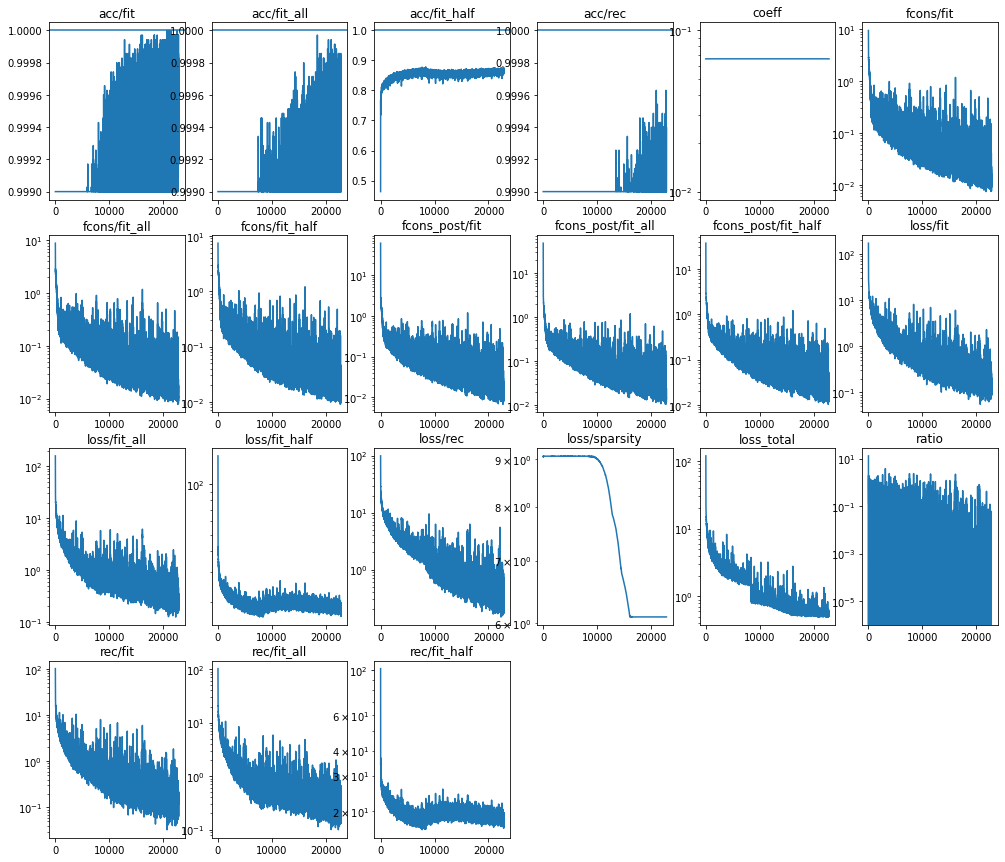

In [93]:
metrics_dict = lstdct2dctlst(metrics_hist)

keys = sorted(metrics_dict.keys())

px = 4
py = 6

assert px * py >= len(keys)

plt.figure(figsize=(17, 15))
for i, key in enumerate(keys, 1):
    plt.subplot(px, py, i)
    plt.title(key)
    data = metrics_dict[key]
    if key.startswith('acc'):
        if np.max(data) >= 0.999:
            data = np.maximum(np.array(data), 0.999)
        plt.axhline(1)
    else:
        plt.yscale('log')
    plt.plot(data)
plt.show()

<AxesSubplot:>

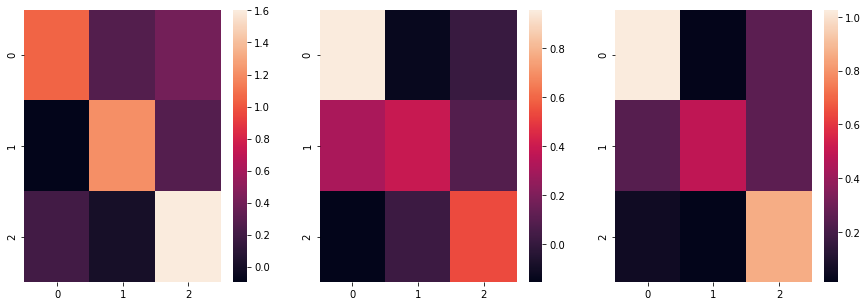

In [94]:
plt.figure(figsize=(15, 5))
# S = nn.Softmax(1)(model_.fc1.weight)
# S = dec.fc1.weight
S = rot1.fc1.weight
Sinv = rot2.fc1.weight
# Sinv = torch.pinverse(S)
plt.subplot(1, 3, 1)
sns.heatmap(S.detach().cpu().numpy())
plt.subplot(1, 3, 2)
sns.heatmap(Sinv.detach().cpu().numpy())
plt.subplot(1, 3, 3)
sns.heatmap((S @ Sinv).abs().detach().cpu().numpy())

tensor([[1.0000, 0.0100, 0.0100, 0.0100, 1.0000],
        [0.0100, 1.0000, 0.0100, 1.0000, 0.0100],
        [0.0100, 0.0100, 0.9999, 0.0100, 1.0000]], device='cuda:0',
       grad_fn=<TBackward>)


<AxesSubplot:>

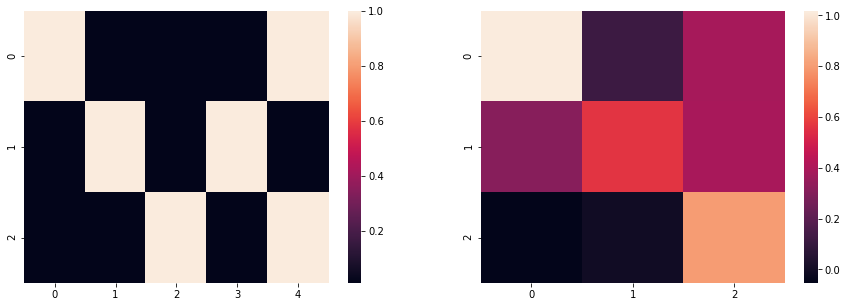

In [95]:
MP = model_.model.switch.probas
plt.figure(figsize=(15, 5))
print(MP.t())
plt.subplot(1, 2, 1)
sns.heatmap(MP.t().detach().cpu().numpy(), vmin=min_proba, vmax=1)
plt.subplot(1, 2, 2)
sns.heatmap((Sinv @ MP.t()[:, :n_f] @ S).detach().cpu().numpy())

(-0.1, 2.0)

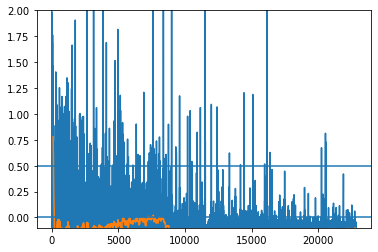

In [96]:
plt.plot(metrics_dict['ratio'])
# plt.yscale('log')
plt.plot(pd.Series(metrics_dict['ratio']).rolling(100).median())
plt.axhline(crit_ratio)
plt.axhline(0)
plt.ylim((-0.1, 2))

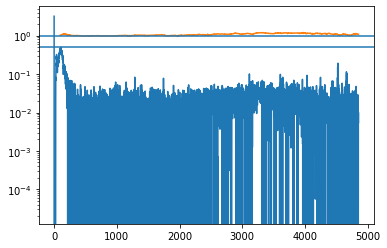

In [76]:
plt.plot(metrics_dict['ratio'])
plt.yscale('log')
plt.plot(pd.Series(metrics_dict['loss/fit']).rolling(100).median() /
         pd.Series(metrics_dict['loss/fit_all']).rolling(100).median())
plt.axhline(crit_ratio)
plt.axhline(1)

In [ ]:
#acc -- too bad

In [ ]:
crit_ratio

In [ ]:
torch.set_num_threads(7)

In [ ]:
list(nn.BatchNorm1d(10).named_parameters())

In [ ]:
from sparse_causal_model_learner_rl.loss.losses import fit_loss_obs_space

In [ ]:
loss = fit_loss_obs_space(model=model_,
                   rot_pre=rot1,
                   rot_post=rot2,
                   obs_x=obs.flatten(start_dim=1),
                   obs_y=obs_next.flatten(start_dim=1),
                   action_x=torch.zeros(0),
                   decoder=dec,
                   reconstructor=rec,
                   model_forward_kwargs={'enable_switch': True},
                   additional_feature_keys=[],
                   loss_local_cache={})['loss']

In [666]:
?make_dot

Signature: make_dot(var, params=None)
Docstring:
Produces Graphviz representation of PyTorch autograd graph.

Blue nodes are the Variables that require grad, orange are Tensors
saved for backward in torch.autograd.Function

Args:
    var: output Variable
    params: dict of (name, Variable) to add names to node that
        require grad (TODO: make optional)
File:      ~/miniconda3/envs/causal/lib/python3.7/site-packages/torchviz/dot.py
Type:      function


In [668]:
from torchviz import make_dot

# make_dot(loss, params=dict(list(model_.named_parameters()) + list(dec.named_parameters()) +
#                            list(rec.named_parameters()) + list(rot1.named_parameters()) +
#                            list(rot2.named_parameters()))).render("rnn_torchviz", format="png")
make_dot(loss).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [660]:
!pip install torchviz

     |████████████████████████████████| 41 kB 223 kB/s eta 0:00:011
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=3521 sha256=672ddd6c57b1202df26df8a9dbf02dea5630a6130b342831c7ebd43487fc1b76
  Stored in directory: /home/sergei/.cache/pip/wheels/10/7b/c8/3af79ec02e294a832c01037bcb38302bbcee0bb020dcbbbd3e
Successfully built torchviz


In [652]:
torch.zeros(0)

tensor([])

['ve2_toy_digits']

In [345]:
env = load_env()

Make environment VectorIncrement-v0 None {}
md -1
md -1


md -1
md -1


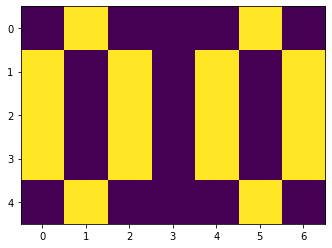

In [346]:
plt.imshow(env.reset())

md -1
md -1


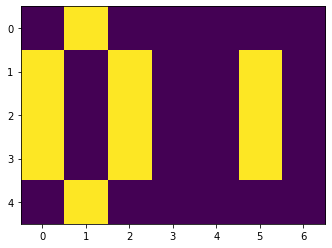

md -1
md -1


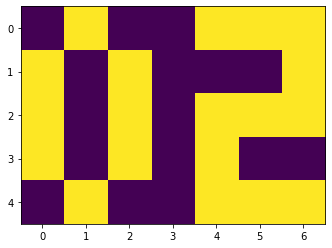

md -1
md -1


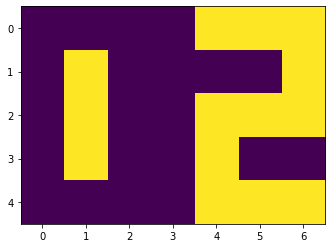

md -1
md -1


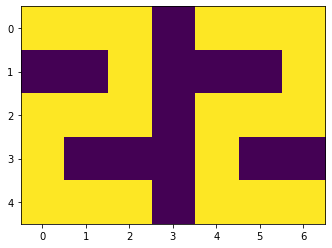

md -1
md -1


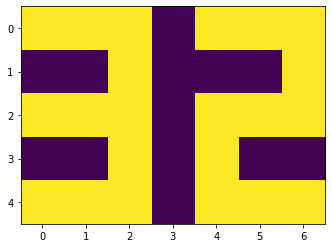

md -1
md -1


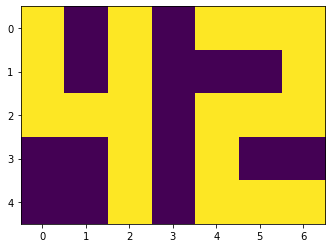

md -1
md -1


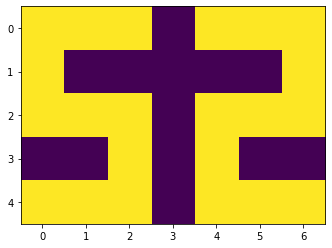

md -1
md -1


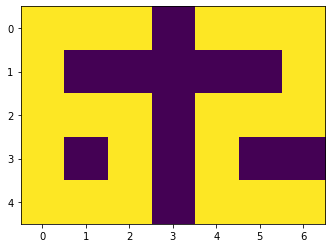

md -1
md -1


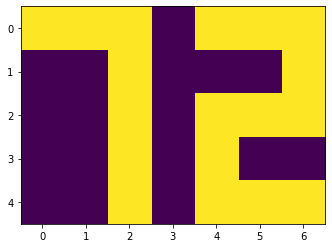

md -1
md -1


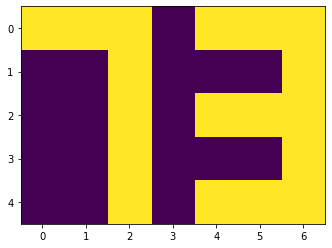

md -1
md -1


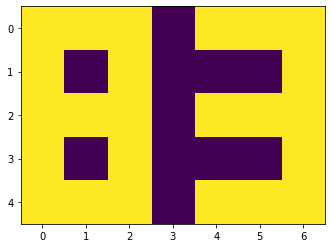

md -1
md -1


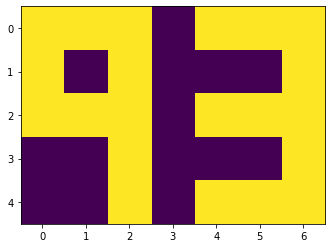

md -1
md -1


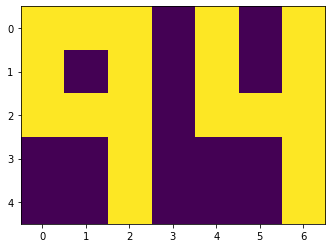

md -1
md -1


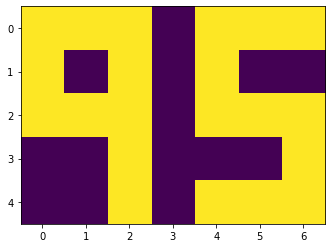

md -1
md -1


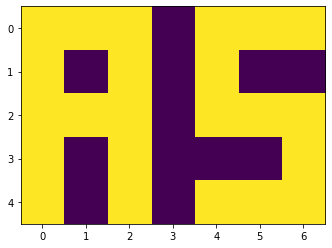

md -1
md -1


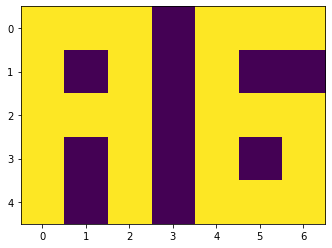

md -1
md -1


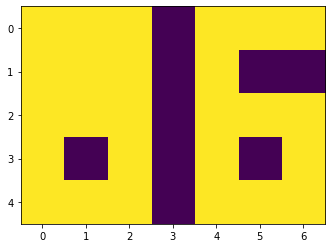

md -1
md -1


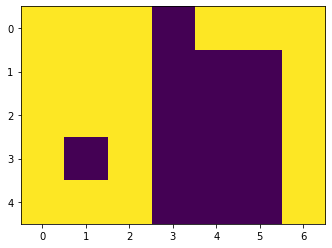

md -1
md -1


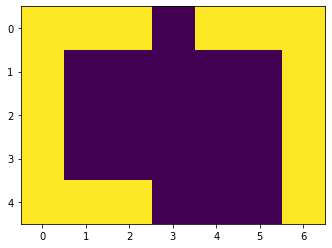

md -1
md -1


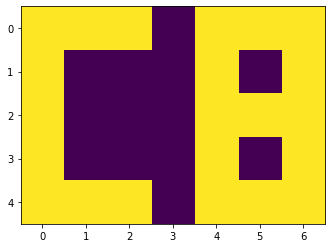

md -1
md -1


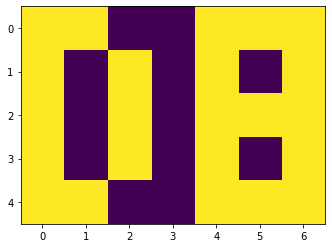

md -1
md -1


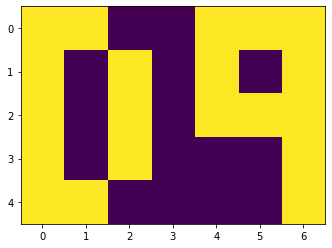

md -1
md -1


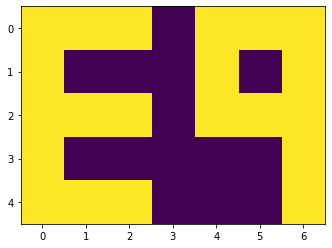

md -1
md -1


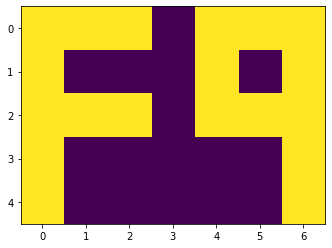

md -1
md -1


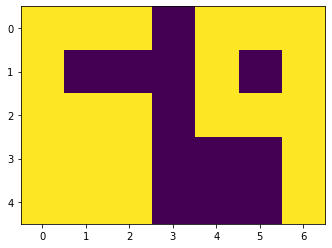

md -1
md -1


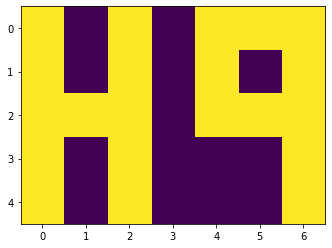

md -1
md -1


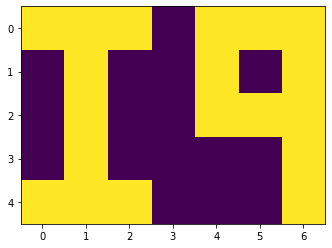

md -1
md -1


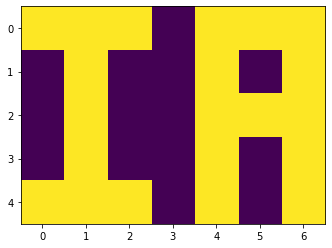

md -1
md -1


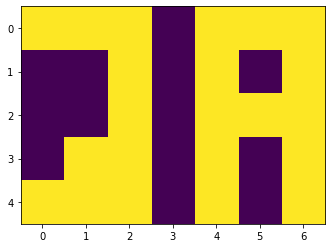

md -1
md -1


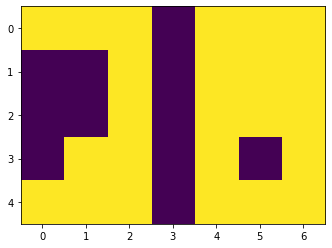

md -1
md -1


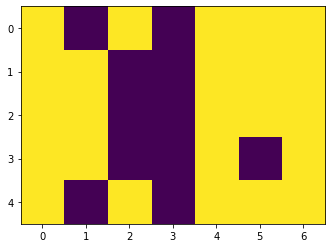

md -1
md -1


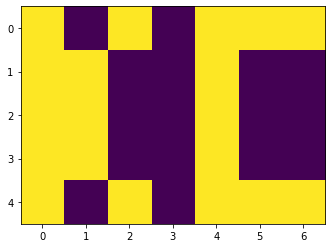

md -1
md -1


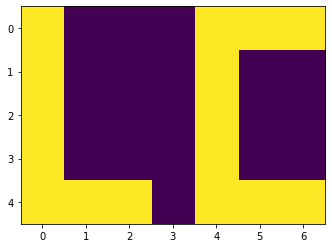

md -1
md -1


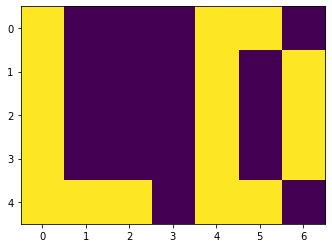

md -1
md -1


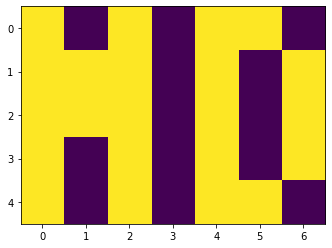

md -1


KeyError: 23
  In call to configurable 'small_int_vector_asimage' (<function small_int_vector_asimage at 0x7f6392e157b8>)

In [347]:
for _ in range(100):
    plt.imshow(env.step(env.action_space.sample())[0])
    plt.show()